In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import LogNorm

import matplotlib
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
import cycler
from datetime import datetime, timedelta
import json
import os
from warnings import filterwarnings

# from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from main import Simulation

filterwarnings('default')
os.makedirs("./plots", exist_ok=True)
%matplotlib inline

In [3]:
plt.rcParams["font.size"] = 30
plt.rcParams["figure.facecolor"] = "white"

pd.options.display.max_rows = 9999

# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.family'] = "Helvetica"

# Figure 1a

![](plots/maszk_sema_vertical.png)

# Figure 1b

In [50]:
# representative contact numbers
repi = pd.read_csv('data/avrContNum.csv',header=None)
repi["start"] = repi[0].map(lambda s: datetime.strptime(s.split("-")[1],"%d/%m/%Y"))
repi["end"] = repi[0].map(lambda s: datetime(datetime.strptime(s.split("-")[1],"%d/%m/%Y").year,datetime.strptime(s.split("-")[1],"%d/%m/%Y").month,int(s.split("-")[0])))
repi.rename({1:"cnum"},axis=1,inplace=True)
repi.drop(0,axis=1,inplace=True)

Data from https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest_responses.csv

In [51]:
# measures

subset_measures = pd.read_csv('data/hungary_measures.csv')\
    .groupby("StartDate").agg(lambda x: list(x))

subset_measures["yoffset"] = 0

subset_measures["datediff"] = np.diff(subset_measures.index,prepend=0)

subset_measures["small_datediff"] = subset_measures["datediff"]<=15

old = False
offset = 0
l = []
for e,f in zip(subset_measures["small_datediff"],subset_measures["PolicyType"]):
    new = e
    if new:
        offset += len(f)
    else:
        if old:
            offset=0
    old = new
    l.append(offset)

subset_measures["offset"] = l

subset_measures["arbitrary_offset"] =0

/tmp/ipykernel_12413/2585194517.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json' mode='r' encoding='UTF-8'>
  json.load(open('../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json'))
/tmp/ipykernel_12413/2585194517.py:7: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json' mode='r' encoding='UTF-8'>
  json.load(open('../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json'))
/tmp/ipykernel_12413/2585194517.py:12: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_topcut_nofilter_2021-12-06.json' mode='r' encoding='UTF-8'>
  json.load(open('../maszk_dynmatrix/data/report_input_topcut_nofilter_2021-12-06.json'))
/tmp/ipykernel_12413/2585194517.py:16: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_topcut_nofilter_2021-12-06.json' mode='r' encoding='

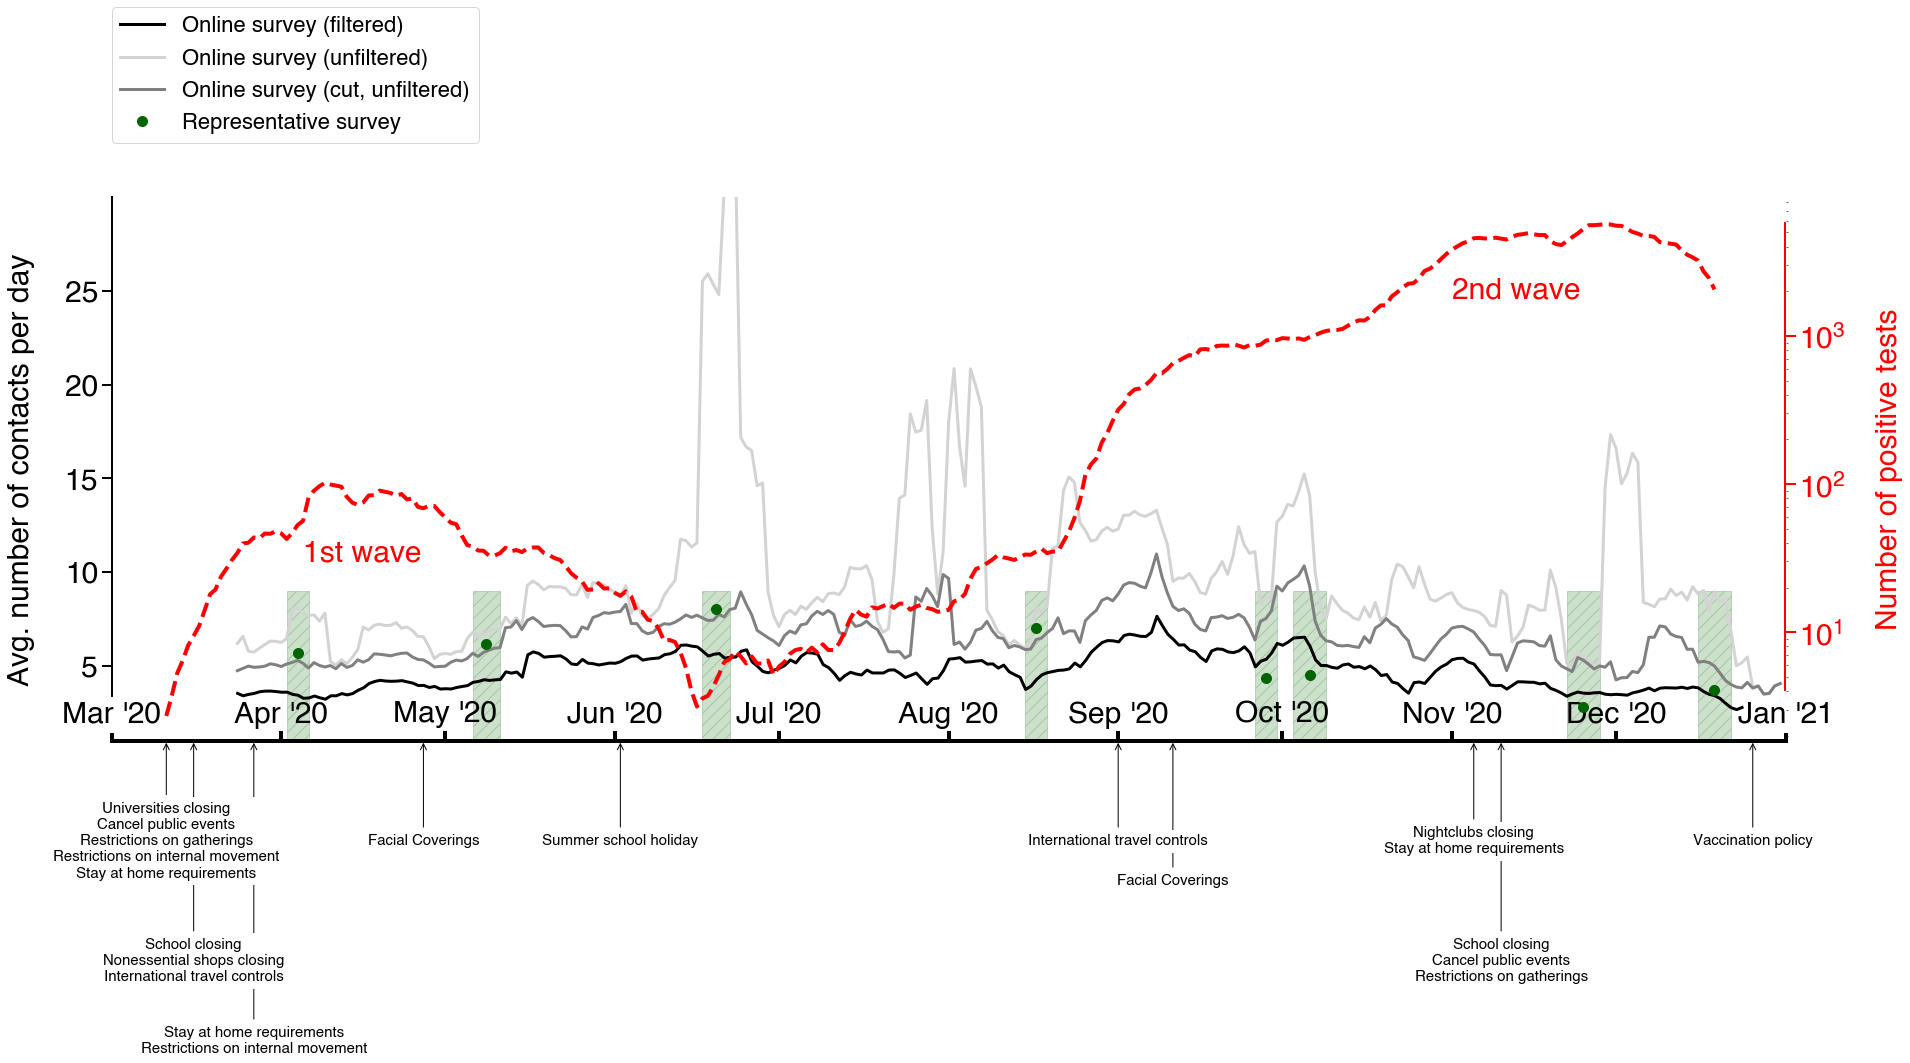

In [87]:
# contact data nofilter
df2 = pd.DataFrame.from_dict(pd.DataFrame(
    json.load(open('../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json'))
)['cnum_avg'].tolist())

df2["datetime"] = pd.DataFrame(
    json.load(open('../maszk_dynmatrix/data/report_input_nofilter_2021-12-06.json'))
)["metadata"].map(lambda d: datetime.strptime(d["start_date"],"%Y-%m-%d"))

# contact data nofilter
df3 = pd.DataFrame.from_dict(pd.DataFrame(
    json.load(open('../maszk_dynmatrix/data/report_input_topcut_nofilter_2021-12-06.json'))
)['cnum_avg'].tolist())

df3["datetime"] = pd.DataFrame(
    json.load(open('../maszk_dynmatrix/data/report_input_topcut_nofilter_2021-12-06.json'))
)["metadata"].map(lambda d: datetime.strptime(d["start_date"],"%Y-%m-%d"))

# contact data
df = pd.DataFrame(
    json.load(open('./contact_matrix/results/dynmatrix_step_1d_window_7d_v15_kid_masked_all.json'))
)
mask = [datetime.fromtimestamp(t)<datetime(2020,12,25) for t in df.start_ts]
mask2 = [t<datetime(2021,1,1) for t in df2.datetime]
mask3 = [t<datetime(2021,1,1) for t in df3.datetime]


fig, ax1 = plt.subplots(1,1,figsize=(30,10))
ax2 = ax1.twinx()

# black axis limits and axis lines
ax1.set_ylim(1,30)
ax1.set_xlim(datetime(2020,3,1),datetime(2021,1,1))
ax1.set_yticks(range(5,30,5))
ax1.spines["bottom"].set_linewidth(4)
ax1.spines["top"].set_linewidth(0)
ax1.spines["left"].set_linewidth(2)
ax1.spines["left"].set_zorder(-1)
ax1.spines["right"].set_linewidth(0)

# red axis axis lines
ax2.spines["top"].set_linewidth(0)
ax2.spines["left"].set_linewidth(0)

ax1.plot([datetime.fromtimestamp(t) for t in df[mask].start_ts],
         df[mask].avg_actual_outside_proxy + df[mask].avg_family,
         'k-', lw=3,label="Online survey (filtered)")
ax1.plot(df2[mask2].datetime, df2[mask2].contact,'-',lw=3,color="lightgrey",label="Online survey (unfiltered)")
ax1.plot(df3[mask3].datetime, df3[mask3].contact,'-',lw=3,color="grey",label="Online survey (cut, unfiltered)")
ax1.set_ylabel("Avg. number of contacts per day",labelpad=30)

# incidence data
sim_1 = Simulation(contact_data_json = 'dynmatrix_step_1d_window_7d_v15_kid_masked_all.json')
# data from the webpage of Ferenci Tamas
mask = ([t<datetime(2020,12,20) for t in sim_1.data.reference_r_eff_data.datetime])&(sim_1.data.reference_r_eff_data["method"]=="Cori")

# casenum
N = 3 # smoothing the curve
ax2.plot(sim_1.data.reference_r_eff_data[mask]["datetime"],np.convolve(sim_1.data.reference_r_eff_data[mask]["casenum"], np.ones(2 * N + 1) / (2 * N + 1), mode='same'),
         'r--', lw=4, label="Official data")
ax2.set_ylabel("Number of positive tests",color="r",labelpad=30)
ax2.semilogy()

# adding annotations to the case numbers
ax2.annotate("1st wave", xy=(datetime(2020,4,5),30), xycoords="data",color="red")
ax2.annotate("2nd wave", xy=(datetime(2020,11,1),1800), xycoords="data",color="red")

# define the date format on the x axis, reformatting xticks
date_form = DateFormatter("%b '%y")
ax1.xaxis.set_major_formatter(date_form)
ax1.tick_params(axis="x",direction="in",pad=-40,length=10,width=4)
ax1.get_xticklabels()[0].set_bbox(dict(fc="white",ec="white"))
ax1.get_xticklabels()[-1].set_bbox(dict(fc="white",ec="white"))


# yaxis ticks
ax2.tick_params(axis="y",colors='r',length=10,width=2)
ax1.tick_params(axis="y",length=10,width=2)


# representative contact numbers
hit=0
for r in repi[1:].iterrows():
    ax1.fill_betweenx([0,9],[r[1]["start"],r[1]["start"]],[r[1]["end"],r[1]["end"]],color="darkgreen",alpha=0.2,hatch="//")
    m = datetime.fromtimestamp((r[1]["start"].to_pydatetime().timestamp() + r[1]["end"].to_pydatetime().timestamp())/2)
    if hit==0:
        ax1.plot(m,r[1]["cnum"],'o',color="darkgreen",markersize=10,label="Representative survey")
        hit=1
    else:
        ax1.plot(m,r[1]["cnum"],'o',color="darkgreen",markersize=10)
        
# legend
ax1.legend(loc=(0,1.1),fontsize=22)

# different NPI measures
for r in subset_measures[::-1].iterrows():
    ax1.annotate(
        "\n".join([e.split(":")[1][1:] for e in r[1]["PolicyType"]]), 
        (datetime.strptime(str(r[1].name),"%Y%m%d"),1),
        (0,-100-r[1].offset*40+r[1]["arbitrary_offset"]),
        xycoords="data",
        textcoords="offset points",
        fontsize=15,
        arrowprops = dict(arrowstyle="->"),
        ha="center",
        va="center",
        bbox=dict(fc=(1.0, 1, 1),ec=(1,1,1,1))
    )

# redrawing the right axis to overcome zorder issue
ax2.spines["right"].set_visible(False)
ax2.vlines(datetime(2021,1,1),4,5900,color='red',lw=4)

plt.savefig("./plots/fig1b_v2.png", dpi=300, bbox_inches="tight")

### Spektralsugarak

In [63]:
repi_mx = pd.read_csv('contact_matrix/results/Repr_SumWDKFMtx_weightnorm.csv',header=None).fillna(0)
repi_mx.index = repi_mx[0].map(lambda s: s.split(":")[0])
repi_mx[0] = repi_mx[0].map(lambda s: float(s.split(":")[1]))
repi_mx = repi_mx.iloc[1:,:]
repi_mx["ts"] = repi_mx.index.map(lambda s: datetime(int(s[3:7]),int(s[0:2]),1).timestamp())
repi_mx["cm"] = repi_mx.iloc[:,0:64].apply(lambda r: np.reshape(list(r),(8,8)),axis=1)

In [58]:
from datetime import timedelta

/home/bokanyie/.anaconda3/lib/python3.8/site-packages/pandas/core/base.py:937: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  new_values = map_f(values, mapper)


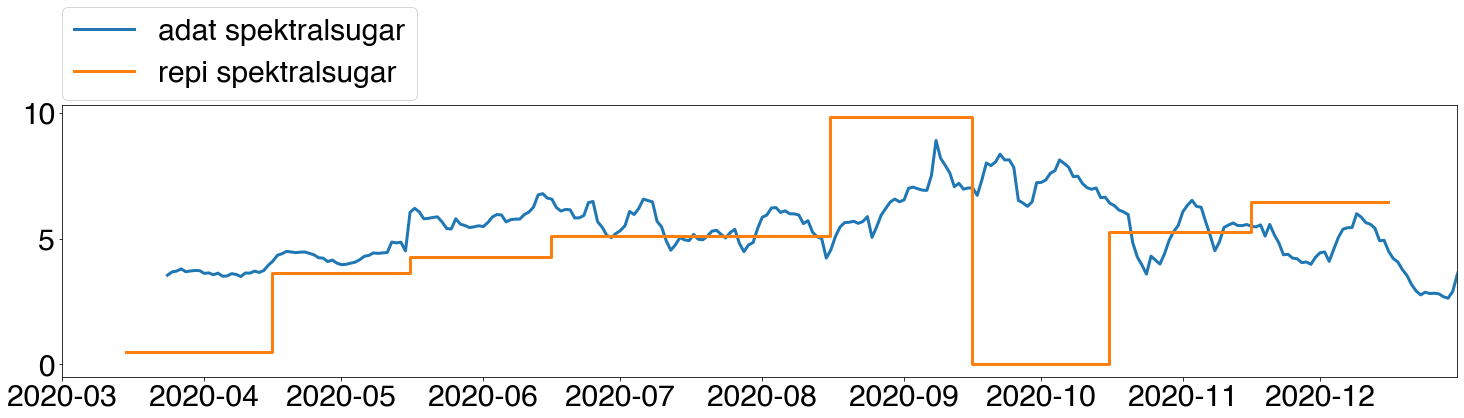

In [88]:
sr = repi_mx["cm"].map(np.array).map(np.linalg.eigvals).map(np.abs).map(lambda t: t[0])
plt.figure(figsize=(25,5))
plt.plot([datetime.fromtimestamp(t) for t in df["start_ts"]],df["contact_matrix"].map(np.matrix).map(np.linalg.eigvals).map(np.abs).map(lambda t: t[0]),lw=3,label="adat spektralsugar")
plt.step([datetime(2020,3,15)]+[datetime.fromtimestamp(t)+timedelta(days=15) for t in repi_mx["ts"]],[sr[0]]+sr.tolist(),lw=3,label="repi spektralsugar")
plt.xlim(datetime(2020,3,1),datetime(2020,12,31))
plt.legend(loc=(0,1.02))

# Figure 2

In [7]:
# simulated R_eff, R_0=1.3, c=0.8, immune True, initial_r0=2.5, initial ratio=0.011, seasonality: truncated cosine
sim = Simulation(contact_data_json='dynmatrix_step_1d_window_7d_v15_kid_masked_all.json')
sim.date_for_calibration = '2020-09-13'
sim.baseline_cm_date = (sim.date_for_calibration, '2020-09-20')
start_time = '2020-03-31'
end_time = '2021-01-26'

sim.is_r_eff_calc = True
sim.r0 = 1.3

c=0.8

sim.initial_r0 = 2.5
sim.init_ratio_recovered = 0.011
sim.seasonality_idx = "truncated_cosine"

sim.simulate(
    start_time=start_time,
    end_time=end_time,
    c=c
)


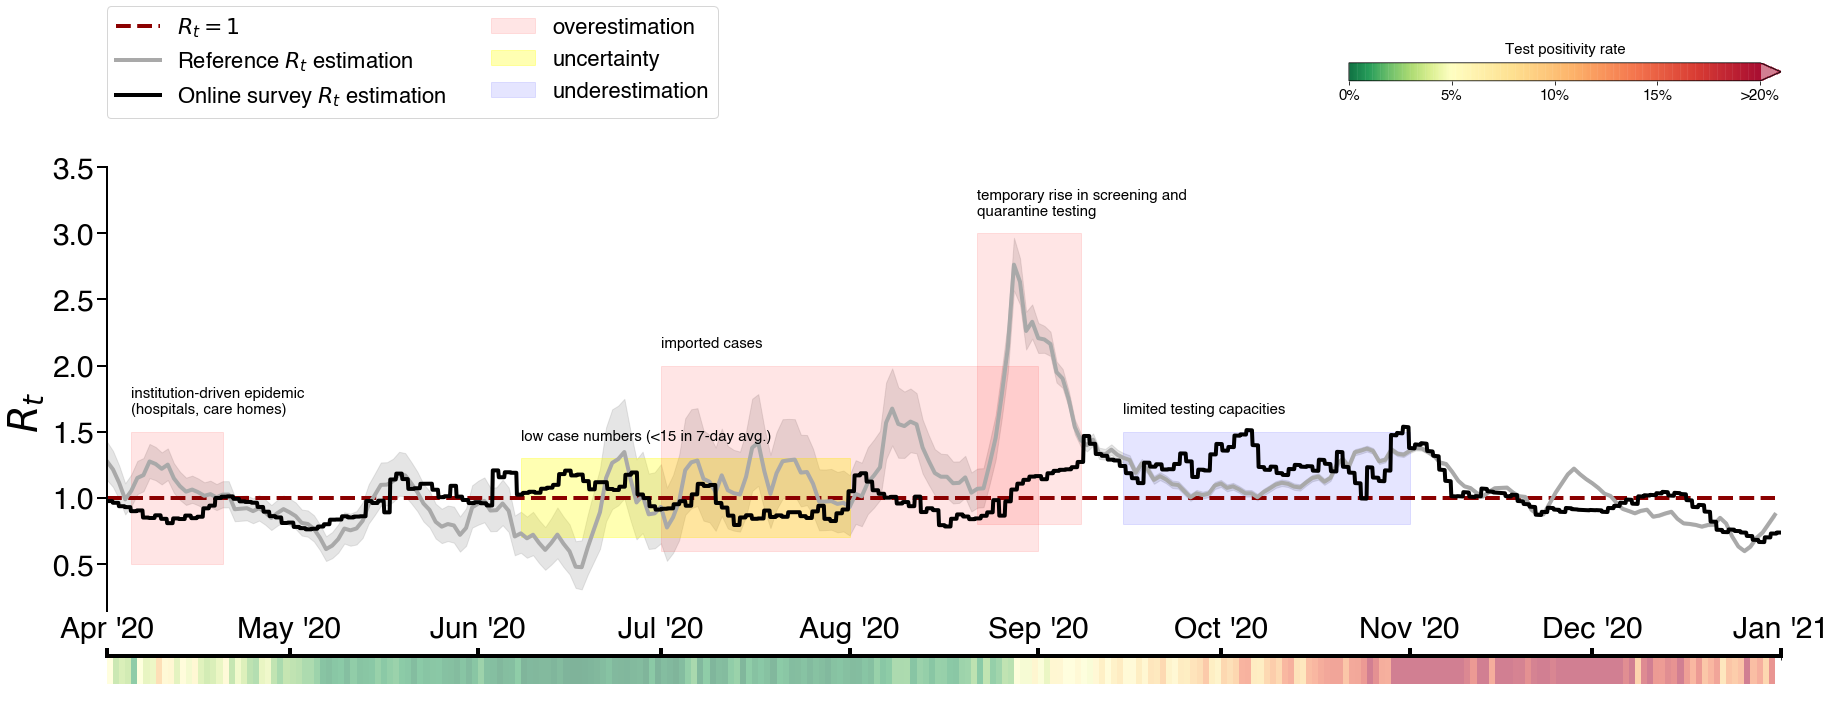

In [9]:
fig, [ax1,stripe] = plt.subplots(2,1,figsize=(30,10),sharex=True,gridspec_kw = dict(height_ratios=[9,1]))

methods = sim.data.reference_r_eff_data["method"].sort_values().unique()
method_mask = (sim.data.reference_r_eff_data["method"] == methods[0])&(sim.data.reference_r_eff_data["datetime"]<datetime(2021,1,1))&((sim.data.reference_r_eff_data["datetime"]>datetime(2020,3,31)))



# ==============================================================================================================
# positivity rate
cmap = plt.get_cmap('RdYlGn_r')
norm = matplotlib.colors.TwoSlopeNorm(vcenter=5,vmin=0,vmax=20)
for y,diff,val in zip(
    sim.data.reference_r_eff_data[method_mask]["datetime"].map(mdates.date2num)[:-1],
    np.diff(sim.data.reference_r_eff_data[method_mask]["datetime"].map(mdates.date2num)),
    sim.data.reference_r_eff_data[method_mask]["pos"][:-1]
):
    stripe.add_patch(Rectangle((y, 0.5), diff, 0.5, alpha=0.5,ec=None,fc=matplotlib.colors.to_hex(cmap(norm(val)))))

# legend for positivity rate
cax_helper = fig.add_axes([1,1,0,0])
cax = fig.add_axes([0.7, 1, 0.2, 0.025])
cax_helper.set_visible(False)
im = cax_helper.imshow([sim.data.reference_r_eff_data[method_mask]["pos"][:-1]], cmap=cmap, norm=norm,alpha=0.5)
cbar = plt.colorbar(im,cax=cax,orientation="horizontal",extend="max", ticks=[0,5,10,15,20],drawedges=False)
cbar.ax.set_title("Test positivity rate",fontsize=15,pad=10)
cbar.ax.set_xticklabels(["0%","5%","10%","15%",">20%"],fontsize=15)
cbar.solids.set_edgecolor("face")


# ================================================================
# annotations

# 1. insitution-driven epidemic (hospitals, care homes)

start = mdates.date2num(datetime(2020,4,5))
end = mdates.date2num(datetime(2020,4,20))
bottom=0.5
top=1.5
ax1.add_patch(Rectangle((start,bottom),end-start,top-bottom,alpha=0.1,ec="red",fc="red",joinstyle="round"))
ax1.annotate("institution-driven epidemic\n(hospitals, care homes)",(start,top+0.1),(0,5),xycoords="data",fontsize=15,textcoords="offset points")


# 2. juni 1 - augusztus 8 alacsony esetszamok


#10
# start = mdates.date2num(datetime(2020,6,1))
# end = mdates.date2num(datetime(2020,8,8))

#15
start = mdates.date2num(datetime(2020,6,8))
end = mdates.date2num(datetime(2020,8,1))


#35
# start = mdates.date2num(datetime(2020,5,19))
# end = mdates.date2num(datetime(2020,8,20))


bottom=0.7
top=1.3
ax1.add_patch(Rectangle((start,bottom),end-start,top-bottom,alpha=0.3,ec="yellow",fc="yellow",joinstyle="round"))
ax1.annotate("low case numbers (<15 in 7-day avg.)",(start,top+0.1),(0,5),xycoords="data",fontsize=15,textcoords="offset points")

# 3. imported cases


start = mdates.date2num(datetime(2020,7,1))
end = mdates.date2num(datetime(2020,9,1))
bottom=0.6
top=2
ax1.add_patch(Rectangle((start,bottom),end-start,top-bottom,alpha=0.1,ec="red",fc="red",joinstyle="round"))
ax1.annotate("imported cases",(start,top+0.1),(0,5),xycoords="data",fontsize=15,textcoords="offset points")

# 4. screening and quarantine testing

start = mdates.date2num(datetime(2020,8,22))
end = mdates.date2num(datetime(2020,9,8))
bottom=0.8
top=3
ax1.add_patch(Rectangle((start,bottom),end-start,top-bottom,alpha=0.1,ec="red",fc="red",joinstyle="round"))
ax1.annotate("temporary rise in screening and\nquarantine testing",(start,top+0.1),(0,5),xycoords="data",fontsize=15,textcoords="offset points")

# 5. limited testing capacities


start = mdates.date2num(datetime(2020,9,15))
end = mdates.date2num(datetime(2020,11,1))
bottom=0.8
top=1.5
ax1.add_patch(Rectangle((start,bottom),end-start,top-bottom,alpha=0.1,ec="blue",fc="blue",joinstyle="round"))
ax1.annotate("limited testing capacities",(start,top+0.1),(0,5),xycoords="data",fontsize=15,textcoords="offset points")

#===============================================================
# reference R_t

x=sim.data.reference_r_eff_data[method_mask]["datetime"]
y1=sim.data.reference_r_eff_data[method_mask]["ci_lower"]
y2=sim.data.reference_r_eff_data[method_mask]["ci_upper"]

# critical line at R_t=1
ax1.plot(x,[1]*len(x),'--',color='darkred',lw=4,label=r"$R_t= 1$")  
# confidence interval for reference R_t
ax1.fill_between(x,y1,y2,color="grey",alpha=0.2)
# reference R_t
x=sim.data.reference_r_eff_data[method_mask]["datetime"],
y=sim.data.reference_r_eff_data[method_mask]["r_eff"]
ax1.plot(x[0],y,'-',color='darkgrey',lw=4,label="Reference $R_t$ estimation")


# ================================================================
# online survey R_t timeline
ax1.plot(
    [datetime.fromtimestamp(t) for t in sim.timestamps if t<datetime(2021,1,1).timestamp()],
    [r for r,t in zip(sim.r_eff_plot,sim.timestamps) if t<datetime(2021,1,1).timestamp()],
    'k-',
    lw=4,
    label="Online survey $R_t$ estimation"
)

# ==============================================================
# legend
# ax1.legend(loc=(0,1.1),fontsize=22)
h,l = ax1.get_legend_handles_labels()

for c,a,label in [('red',0.1,'overestimation'),('yellow',0.3,'uncertainty'),('blue',0.1,'underestimation')]:
    h.append(Patch(color=c,alpha=a,label=label))
    
ax1.legend(loc=(0,1.1),ncol=2,handles=h,fontsize=22)

# ================================================================
# axis formatting
# x
date_form = DateFormatter("%b '%y")
stripe.xaxis.set_major_formatter(date_form)
stripe.tick_params(axis="x",length=10,width=4)
stripe.spines["top"].set_linewidth(4)
stripe.set_xlim(datetime(2020,4,1),datetime(2021,1,1))
ax1.spines["top"].set_linewidth(0)
ax1.spines["bottom"].set_linewidth(0)
stripe.spines["bottom"].set_linewidth(0)
stripe.xaxis.tick_top()

# y
ax1.spines["right"].set_linewidth(0)
stripe.spines["left"].set_linewidth(0)
stripe.spines["right"].set_linewidth(0)
stripe.yaxis.set_visible(False)
ax1.set_ylabel(r"$R_t$",fontsize=40)
ax1.spines["left"].set_linewidth(2)
ax1.tick_params(axis="y",length=10,width=2)
ax1.set_ylim(-0.2,3.5)
ax1.set_yticks(np.linspace(0.5,3.5,num=7))
bbox = dict(boxstyle="round", ec="white", fc="white")
plt.setp(stripe.get_xticklabels(), backgroundcolor="white")


# ==================================================================
# final adjustment and save figure
plt.subplots_adjust(hspace=0)
fig.savefig("./plots/fig2.png",bbox_inches="tight",dpi=300)

# Seasonality

In [24]:
def seasonality_truncated_cos(t: float, c0: float, origin: str,
                              trunc_val: float) -> float:
    """
    Theoretical truncated cosine seasonality function for simulating seasonality of epidemic spread.
    It is assumed, that efficiency of the spread is larger during winter time, less during summer time.
    The period of the function is 366 days.
    :param t: float, actual date in timestamp
    :param c0: float, seasonality factor for original cosine seasonality
    :param origin: str, date string for original cosine seasonality
    :param trunc_val: float, truncation value
    :return: float, seasonality value
    """
    # Calculate elapsed time from beginning of the year in dates
    jan_1 = '2019-01-01'
    d = (t - datetime.strptime(jan_1, '%Y-%m-%d').timestamp()) / (24 * 3600)
    # Calculate elapsed time of seasonality peak from beginning of the year
    d_peak = (datetime.strptime(origin, '%Y-%m-%d').timestamp() -
              datetime.strptime(jan_1, '%Y-%m-%d').timestamp()
              ) / (24 * 3600) % 366

    # Local function for calculating cosine seasonality based in input day values
    def seasonality_cos_d(c: float, day: float, day_peak: float):
        return 0.5 * c0 * np.cos(2 * np.pi * (day - day_peak) / 366) + (1.0 - 0.5 * c)

    # Transform actual day to [0, 365] and apply mirroring for proper truncation
    d_mod = d % 366
    if d_mod > 366 / 2:
        d_mod = 366 - d_mod
    # Calculate normed seasonality value (norming by peak size)
    normed_value = seasonality_cos_d(c=c0, day=d_mod, day_peak=d_peak) / \
        seasonality_cos_d(c=c0, day=d_peak, day_peak=d_peak)
    # Apply truncation
    calc_val = min(max(normed_value, trunc_val), 1.0)
    # In interval [0, d_peak], the seasonality value is constant and it is at its maximum
    if d_mod < d_peak:
        output = 1.0
    else:
        output = calc_val
    return output

def seasonality_truncated_cos_wrap(t: float):
            return seasonality_truncated_cos(t=t, c0=0.8, origin='2020-02-01',
                                             trunc_val=0.6)

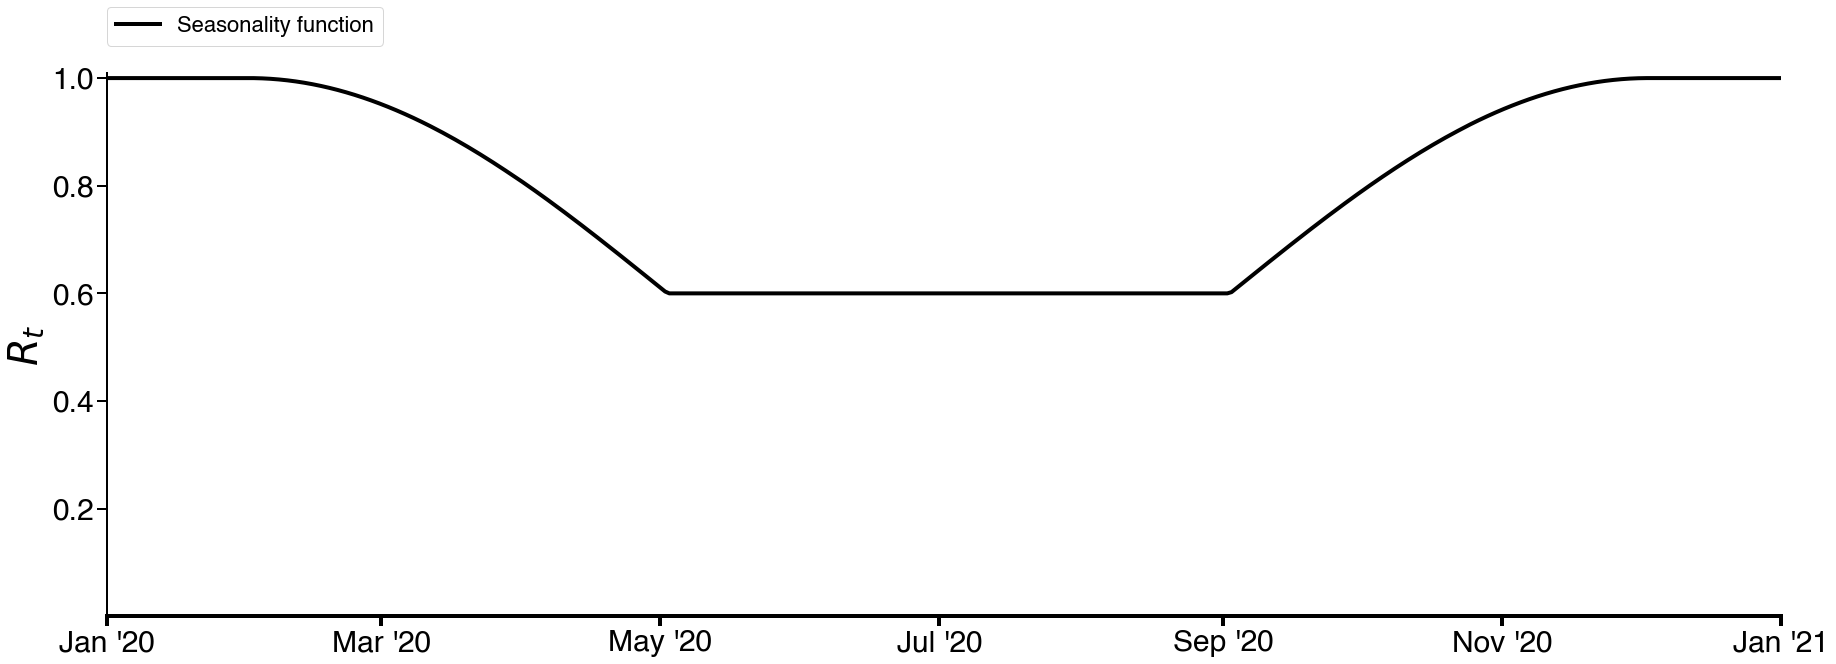

In [25]:
fig, ax1 = plt.subplots(1,1,figsize=(30,10))

x = [datetime.fromtimestamp(t) for t in np.linspace(datetime(2020,1,1).timestamp(),datetime(2021,1,1).timestamp(),400)]
y = [seasonality_truncated_cos_wrap(t) for t in np.linspace(datetime(2020,1,1).timestamp(),datetime(2021,1,1).timestamp(),400)]
# xaxis format
date_form = DateFormatter("%b '%y")
ax1.xaxis.set_major_formatter(date_form)
ax1.tick_params(axis="x",length=10,width=4)
ax1.spines["bottom"].set_linewidth(4)
ax1.set_xlim(datetime(2020,1,1),datetime(2021,1,1))
ax1.spines["top"].set_linewidth(0)
ax1.spines["right"].set_linewidth(0)

# yaxis format
ax1.set_ylabel(r"$R_t$",fontsize=40)
ax1.set_yticks(np.linspace(0.2,1,5))
ax1.spines["left"].set_linewidth(2)
ax1.tick_params(axis="y",length=10,width=2)

ax1.plot(x,y,'k-',lw=4,label="Seasonality function")
ax1.set_ylim(0,1.01)

ax1.legend(loc=(0,1.05), fontsize=22)
fig.savefig('./plots/seasonality.png',dpi=200,bbox_inches="tight")

# Map for schema diagram

In [ ]:
import geopandas as gpd

df = gpd.read_file('data/jaras2015/jaras2015.shp')
df["geometry"] = df.buffer(10)

df.unary_union

df2 = gpd.GeoDataFrame([df.unary_union]).rename({0:"geometry"},axis=1).set_geometry("geometry")

import matplotlib.pyplot as plt

df2.boundary.simplify(50).plot(color='#A5221B',lw=12)
plt.axis("off")

# Colorscheme

https://coolors.co/gradient-palette/fdb58c-930404?number=7

In [ ]:
["#FDB58Cff",
"#EB9875ff",
"#DA7A5Fff",
"#C85D48ff",
"#B63F31ff",
"#A5221Bff",
"#930404ff"]

# Contact matrix for schema diagram

In [ ]:
import matplotlib.colors as mcolors

In [ ]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [ ]:
colors = ["#FDB58C","#EB9875","#DA7A5F","#C85D48","#B63F31","#A5221B","#930404"]

cm = get_continuous_cmap(colors)

In [ ]:
df = pd.DataFrame(sim.data.contact_data_json).set_index("start_date")
z  = np.log10(np.array(df.loc['2020-09-15']['contact_matrix']) + 1e-4)
plt.imshow(z,cmap=cm)

plt.gca().invert_yaxis()
plt.axis('off')

# Distributions

In [4]:
# contact data nofilter with user marginal distributions
df3 = pd.DataFrame.from_dict(pd.DataFrame(
    json.load(open('../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json'))
)['weights'].map(lambda x: x["distributions"]).tolist())


/tmp/ipykernel_12413/269805013.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json' mode='r' encoding='UTF-8'>
  json.load(open('../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json'))


In [13]:
ksh_marginals_adults = {
    'settlement_category':
        dict(
            zip(
                ['1-Budapest', '2-megye jogu varos', '3-varos', '4-kozseg'],
                # TODO: 0.31 volt 0.32 helyett, nem adodik ossze 100-ra!
                [0.18, 0.2, 0.32, 0.3]
            )
        ), 
    'age_group6':
        dict(
            zip(
# merging two oldest age groups in adults
#                 [1., 2., 3., 4., 5.],
#                 [.18,.27,.24,.16,.15]
                [1.,2.,3.,4.],
                [0.18,0.27,0.24,0.31]
            )
        ),
    'education3': dict(
            zip(
                [1., 2., 3.],
                [0.42, 0.36, 0.22]
            )
        ),
    'work_gender1': dict(
        zip(
            ['1-ferfi es dolgozik', '2-no es dolgozik','3-ferfi es NEM dolgozik', '4-no es NEM dolgozik'],
            [0.29, 0.25, 0.18, 0.28]    
        )
    ),
    "is_central_region": dict(
        zip(
            [1., 2.],
            [.31,.69]               
        )
    )
}

In [14]:
col_labels = {
    "age_group6":"Age category",
    "work_gender1":"Employment status",
    "education3":"Education",
    "settlement_category":"Settlement type",
    "is_central_region":"Central Hungary"
}

col_elements = {
    "age_group6": {
        '1.0':'18-29',
        '2.0':'30-33',
        '3.0':'45-59',
        '4.0':'60+'
    },
    "work_gender1": {
        '1-ferfi es dolgozik':'working M',
        '2-no es dolgozik':'working F',
        '3-ferfi es NEM dolgozik':'not working M',
        '4-no es NEM dolgozik':'not working F',
    },
    "settlement_category":{
        '1-Budapest':'Capital',
        '2-megye jogu varos':'Larger city',
        '3-varos':'Smaller city',
        '4-kozseg':'Village'
    },
    "education3":{
        '1.0':"max. vocational",
        '2.0':"high school",
        '3.0':"college degree"
    },
    "is_central_region":{
        '1.0':"Yes",
        '2.0':"No"
    }
}

colors = [
"#ea8c55ff",
"#c75146ff",
"#ad2e24ff",
"#81171bff",
"#540804ff"
]

In [15]:
from matplotlib.gridspec import GridSpec

/tmp/ipykernel_12413/504795966.py:30: ResourceWarning: unclosed file <_io.TextIOWrapper name='../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json' mode='r' encoding='UTF-8'>
  json.load(open('../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json'))


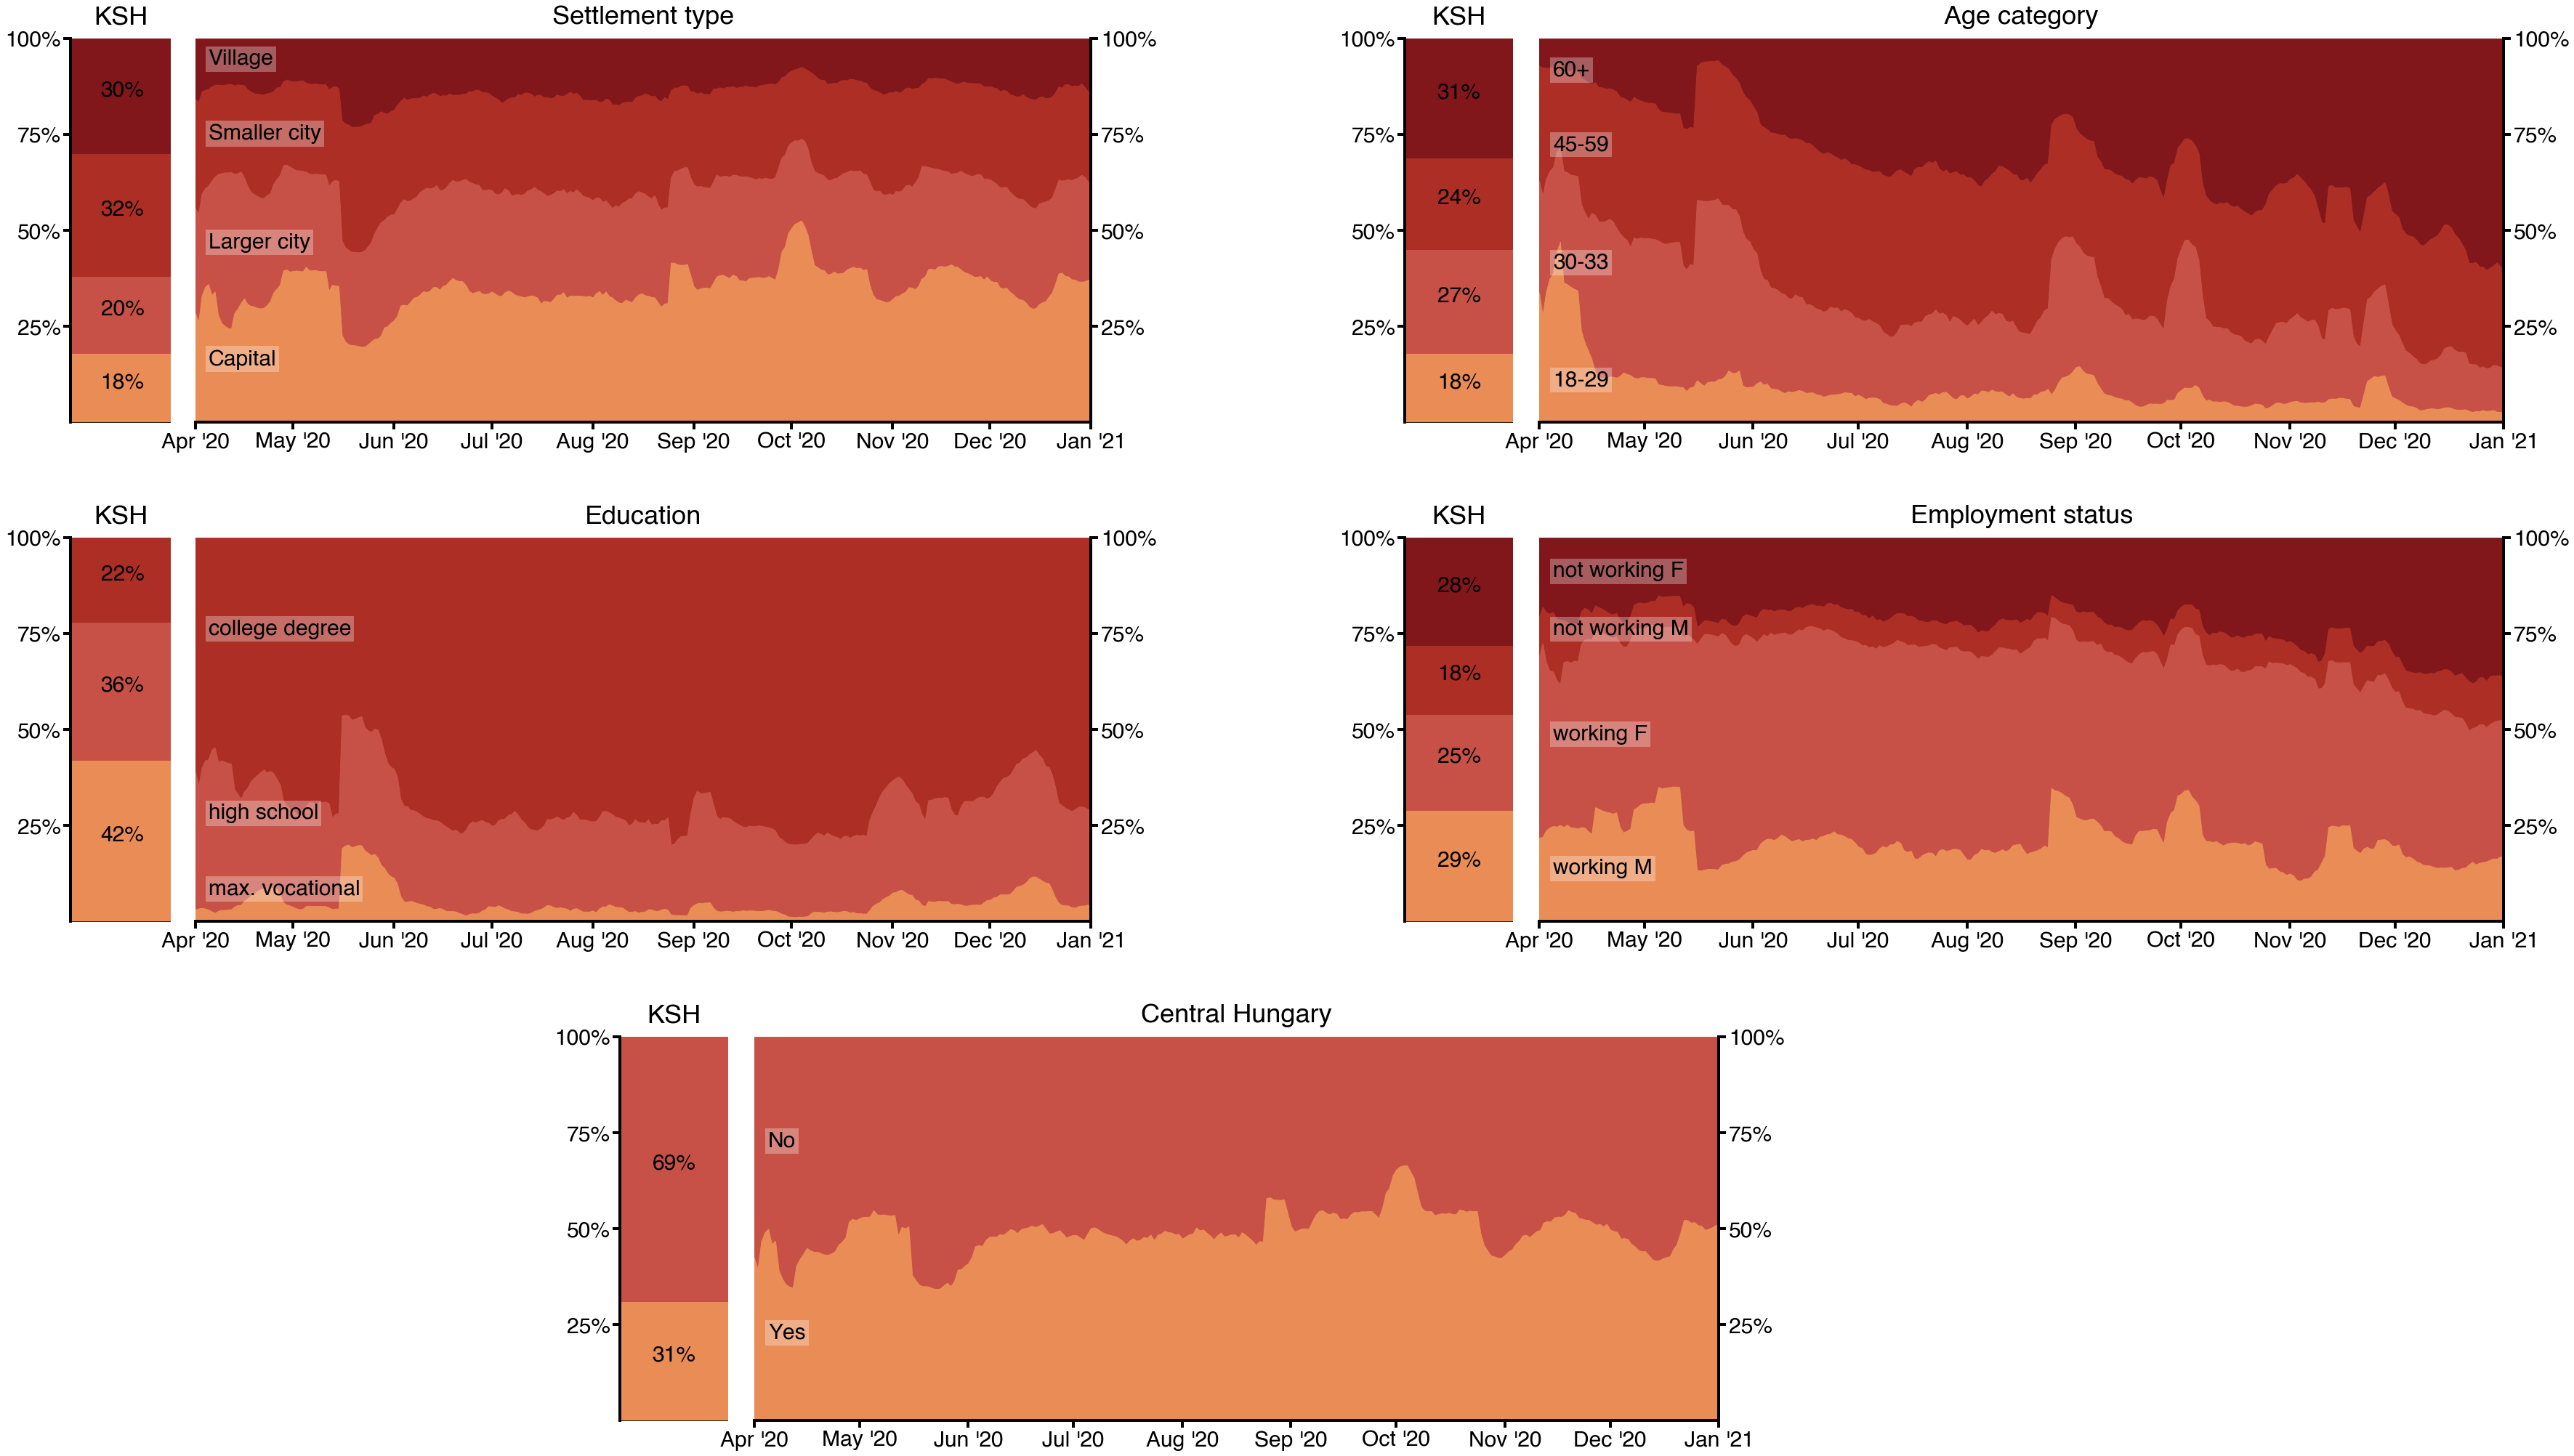

In [40]:
fig = plt.figure(figsize=(60,35))
gs1 = GridSpec(3, 2, right=0.45, width_ratios = [1,9])
gs2 = GridSpec(3, 2, left=0.55, width_ratios = [1,9])
gs3 = GridSpec(3, 2, left=0.3,right=0.65, width_ratios = [1,9])

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs2[0,0])
ax4 = fig.add_subplot(gs2[0,1])
ax5 = fig.add_subplot(gs1[1,0])
ax6 = fig.add_subplot(gs1[1,1])
ax7 = fig.add_subplot(gs2[1,0])
ax8 = fig.add_subplot(gs2[1,1])
ax9 = fig.add_subplot(gs3[2,0])
ax10 = fig.add_subplot(gs3[2,1])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10] 
yt = np.linspace(0,1,5)[1:]

# temporal distributions of users
ax = axs[1::2]
for i,col in enumerate(["settlement_category", "age_group6", "education3", "work_gender1", "is_central_region"]):
    # creating dataframe for each variable from main dataframe
    temp = pd.DataFrame.from_dict(df3[col].tolist())
    ksh_temp = np.cumsum([v for k,v in ksh_marginals_adults[col].items()])
    # normalizing counts
    temp = temp.divide(temp.sum(axis=1),axis=0).cumsum(axis=1)
    # adding the date
    temp.index = pd.DataFrame(
        json.load(open('../maszk_dynmatrix/data/report_input_distr_sigma2_2021-12-06.json'))
    )["metadata"].map(lambda d: datetime.strptime(d["start_date"],"%Y-%m-%d"))
    
    # offsetting legend
    if col == "age_group6":
        offset = -0.05
    elif col == "education3":
        offset = 0.05
    else:
        offset = 0
    # adding plots
    for k in range(len(temp.columns))[::-1]:
        if k==0:
            ax[i].fill_between(temp.index,0,temp.iloc[:,k],color=colors[k])
            ax[i].annotate(col_elements[col][temp.columns[k]],(datetime(2020,4,5),np.mean(temp.iloc[0:30,k])/2+offset),xycoords='data',bbox=dict(fc="white", alpha=0.3, lw=0))
        else:
            ax[i].fill_between(temp.index,temp.iloc[:,k-1],temp.iloc[:,k],color=colors[k])
            ax[i].annotate(col_elements[col][temp.columns[k]],(datetime(2020,4,5),np.mean((temp.iloc[0:30,k-1]+temp.iloc[0:30,k]))/2+offset),xycoords='data',bbox=dict(fc="white", alpha=0.3, lw=0))

    ax[i].set_title(col_labels[col],pad=20)
    ax[i].set_ylim(0,1)

    # x axis formatting to be similar to the previous plots
    date_form = DateFormatter("%b '%y")
    ax[i].xaxis.set_major_formatter(date_form)
    ax[i].tick_params(axis="x",length=10,width=4)
    ax[i].tick_params(axis="y",length=10,width=4)
    ax[i].spines["bottom"].set_linewidth(4)
    ax[i].spines["right"].set_linewidth(4)
    ax[i].set_xlim(datetime(2020,4,1),datetime(2021,1,1))
    ax[i].spines["top"].set_linewidth(0)
    ax[i].spines["left"].set_linewidth(0)
    
    # axis percentages
    ax[i].set_yticks(yt)
    ax[i].set_yticklabels([str(int(i))+"%" for i in 100*yt])
    ax[i].yaxis.tick_right()
    
# KSH data
ax = axs[::2]
for i,col in enumerate(["settlement_category", "age_group6", "education3", "work_gender1", "is_central_region"]):
    temp = np.cumsum([v for k,v in ksh_marginals_adults[col].items()])
    temp2 = [v for k,v in ksh_marginals_adults[col].items()]
    
    
    # adding plots
    for k in range(len(temp)):
        if k==0:
            ax[i].fill_between([0,1],[0,0],[temp[k],temp[k]],color=colors[k])
            ax[i].annotate("%.0f%%" % (temp2[k]*100),(0.3,temp[k]/2),xycoords='data')
        else:
            ax[i].fill_between([0,1],[temp[k-1],temp[k-1]],[temp[k],temp[k]],color=colors[k])
            ax[i].annotate("%.0f%%" % (temp2[k]*100),(0.3,(temp[k-1]+temp[k])/2),xycoords='data')

    
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,1)
    ax[i].xaxis.set_visible(False)
    ax[i].set_title("KSH",pad=20)
    ax[i].tick_params(axis="y",length=10,width=4)
    ax[i].spines["top"].set_linewidth(0)
    ax[i].spines["right"].set_linewidth(0)
    ax[i].spines["left"].set_linewidth(4)
    
    ax[i].set_yticks(yt)
    ax[i].set_yticklabels([str(int(i))+"%" for i in 100*yt])

plt.subplots_adjust(wspace=0.05,hspace=0.3)
plt.savefig('./plots/population_distributions.png',dpi=300,bbox_inches="tight")